In [1]:
import random
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
data = [
    pd.read_csv(p, sep='|', header=0, index_col=None)
    for p in tqdm(list(Path('training').iterdir()))
]

data_validation = [
    pd.read_csv(p, sep='|', header=0, index_col=None)
    for p in tqdm(list(Path('training_setB').iterdir()))
]

  0%|          | 0/20336 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [3]:
HAS_SEPSIS_IDX = pd.Series([i for i, d in enumerate(data) if 1 in d.SepsisLabel.values])
NO_SEPSIS_IDX = pd.Series([i for i, d in enumerate(data) if 0 in d.SepsisLabel.values])
HAS_SEPSIS_ONSET_IDX = pd.Series([i for i, d in enumerate(data) if 1 in d.SepsisLabel.values and 0 in d.SepsisLabel.values])
print(f'''
Has Sepsis: {len(HAS_SEPSIS_IDX)}
Has Sepsis, with onset: {len(HAS_SEPSIS_ONSET_IDX)}
No Sepsis: {len(NO_SEPSIS_IDX)}
Has Sepsis / No Sepsis: {len(HAS_SEPSIS_IDX) / len(NO_SEPSIS_IDX):0.2f}
''')


Has Sepsis: 1790
Has Sepsis, with onset: 1587
No Sepsis: 20133
Has Sepsis / No Sepsis: 0.09



In [4]:
assert all(d.ICULOS.is_monotonic for d in data)
ICU_STAY = pd.Series([max(d.ICULOS.values) for d in data])
pd.DataFrame([
    ICU_STAY[HAS_SEPSIS_IDX].describe(), 
    ICU_STAY[HAS_SEPSIS_ONSET_IDX].describe(),
    ICU_STAY[NO_SEPSIS_IDX].describe(),
], index=['ICU hours with Sepsis', 'ICU hours with Sepsis onset', 'ICU hours without Spesis']).transpose()

,ICU hours with Sepsis,ICU hours with Sepsis onset,ICU hours without Spesis
count,1790.000000,1587.000000,20133.000000
mean,59.544693,65.974165,40.081657
std,57.826063,58.367633,22.455431
min,8.000000,10.000000,8.000000
25%,17.000000,22.000000,26.000000
50%,38.000000,46.000000,40.000000
75%,81.000000,90.000000,48.000000
max,336.000000,336.000000,336.000000


# XGBoost Trial

In [5]:
from sklearn.model_selection import train_test_split

drop_features = [] #['HospAdmTime', 'ICULOS', 'Age']
random.seed(100)
np.random.seed(100)

full_dataset = pd.concat(data, axis='rows').drop(drop_features, axis='columns')
X = full_dataset.drop('SepsisLabel', axis='columns')
y = full_dataset['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)


In [6]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight

sample_weight = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train,
)

params = {
    'objective': 'binary:logistic', 
    'n_estimators': 20,
}
model = XGBClassifier(**params, use_label_encoder=False)
model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='logloss',
    sample_weight=sample_weight,
)

[0]	validation_0-logloss:0.63224	validation_1-logloss:0.63244
[1]	validation_0-logloss:0.59563	validation_1-logloss:0.59610
[2]	validation_0-logloss:0.57040	validation_1-logloss:0.57099
[3]	validation_0-logloss:0.55424	validation_1-logloss:0.55507
[4]	validation_0-logloss:0.54126	validation_1-logloss:0.54213
[5]	validation_0-logloss:0.53213	validation_1-logloss:0.53303
[6]	validation_0-logloss:0.52570	validation_1-logloss:0.52670
[7]	validation_0-logloss:0.52136	validation_1-logloss:0.52251
[8]	validation_0-logloss:0.51600	validation_1-logloss:0.51713
[9]	validation_0-logloss:0.51270	validation_1-logloss:0.51386
[10]	validation_0-logloss:0.50941	validation_1-logloss:0.51063
[11]	validation_0-logloss:0.50545	validation_1-logloss:0.50663
[12]	validation_0-logloss:0.49909	validation_1-logloss:0.50037
[13]	validation_0-logloss:0.49715	validation_1-logloss:0.49852
[14]	validation_0-logloss:0.49266	validation_1-logloss:0.49408
[15]	validation_0-logloss:0.48922	validation_1-logloss:0.49077
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=24, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

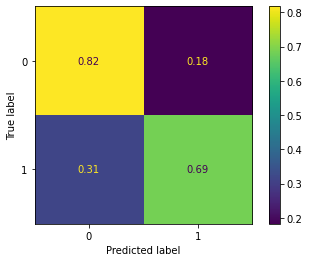

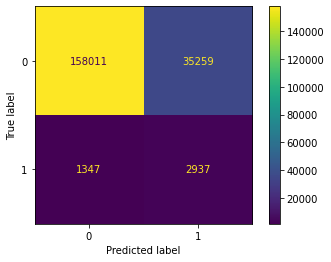

In [7]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, normalize='true')
plot_confusion_matrix(model, X_test, y_test)

In [8]:
from sklearn.metrics import f1_score, recall_score, precision_score
y_pred = model.predict(X_test)
(
    f1_score(y_true=y_test, y_pred=y_pred),
    recall_score(y_true=y_test, y_pred=y_pred),
    precision_score(y_true=y_test, y_pred=y_pred),
)


(0.13827683615819208, 0.6855742296918768, 0.07689286836317939)

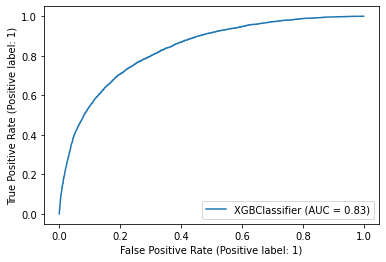

In [9]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X_test, y_test)

# XGBoost Validation

In [10]:
validation_dataset = pd.concat(data_validation, axis='rows').drop(drop_features, axis='columns')
X_valid = validation_dataset.drop('SepsisLabel', axis='columns')
y_valid = validation_dataset['SepsisLabel']

In [11]:
from sklearn.metrics import f1_score, recall_score, precision_score
y_pred = model.predict(X_valid)
(
    f1_score(y_true=y_valid, y_pred=y_pred),
    recall_score(y_true=y_valid, y_pred=y_pred),
    precision_score(y_true=y_valid, y_pred=y_pred),
)

(0.08599390341729504, 0.42263450834879407, 0.04786669608430254)

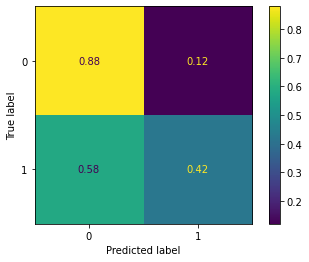

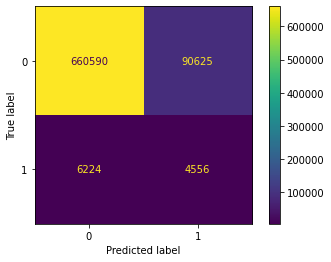

In [12]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_valid, y_valid, normalize='true')
plot_confusion_matrix(model, X_valid, y_valid)

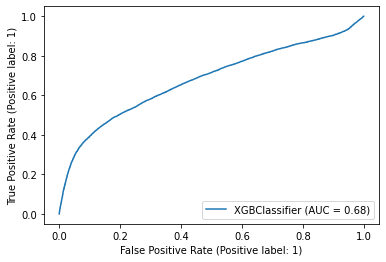

In [13]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X_valid, y_valid)

# Insights (?), and santity checks

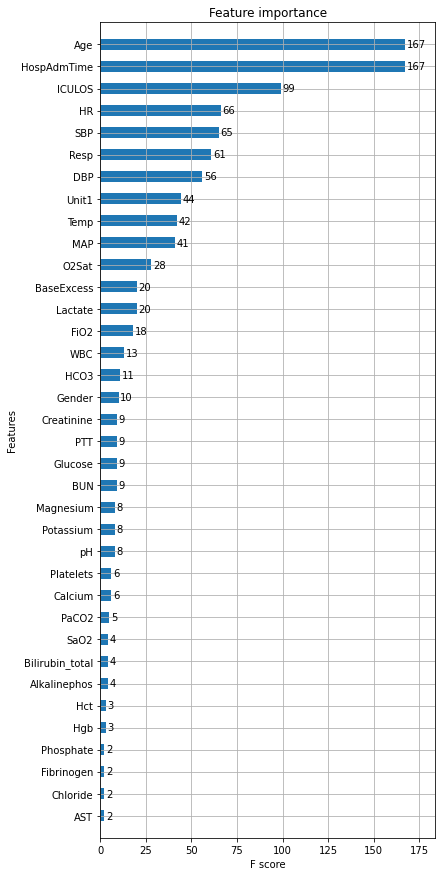

In [14]:
from xgboost.plotting import plot_importance

ax = plot_importance(model, height=0.5)
ax.figure.set_figheight(15)